In [39]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
from scipy import stats as st

%matplotlib inline
sns.set_style("whitegrid")
sns.set_context({"figure.figsize": (15, 7.5)})

In [2]:
# load in the dataset into a pandas dataframe, print statistics
loanData = pd.read_csv('prosperLoanData.csv')

In [3]:
# high-level overview of data shape and composition
print(loanData.shape)
print(loanData.dtypes)
print(loanData.head(10))

(113937, 81)
ListingKey                              object
ListingNumber                            int64
ListingCreationDate                     object
CreditGrade                             object
Term                                     int64
LoanStatus                              object
ClosedDate                              object
BorrowerAPR                            float64
BorrowerRate                           float64
LenderYield                            float64
EstimatedEffectiveYield                float64
EstimatedLoss                          float64
EstimatedReturn                        float64
ProsperRating (numeric)                float64
ProsperRating (Alpha)                   object
ProsperScore                           float64
ListingCategory (numeric)                int64
BorrowerState                           object
Occupation                              object
EmploymentStatus                        object
EmploymentStatusDuration               float64


In [4]:
# descriptive statistics for numeric variables
print(loanData.describe())

       ListingNumber           Term    BorrowerAPR   BorrowerRate  \
count   1.139370e+05  113937.000000  113912.000000  113937.000000   
mean    6.278857e+05      40.830248       0.218828       0.192764   
std     3.280762e+05      10.436212       0.080364       0.074818   
min     4.000000e+00      12.000000       0.006530       0.000000   
25%     4.009190e+05      36.000000       0.156290       0.134000   
50%     6.005540e+05      36.000000       0.209760       0.184000   
75%     8.926340e+05      36.000000       0.283810       0.250000   
max     1.255725e+06      60.000000       0.512290       0.497500   

         LenderYield  EstimatedEffectiveYield  EstimatedLoss  EstimatedReturn  \
count  113937.000000             84853.000000   84853.000000     84853.000000   
mean        0.182701                 0.168661       0.080306         0.096068   
std         0.074516                 0.068467       0.046764         0.030403   
min        -0.010000                -0.182700       0.

### What is the structure of your dataset?

There are 113,937 loan application in the dataset with 81 features. Most variables are numeric in nature, but the variables. 

### What is/are the main feature(s) of interest in your dataset?

Here, I'm most interested in figuring out what features are best for predicting the current loan status in the dataset.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect that credit score will have the strongest effect on each loan status: the higher the score, the higher probability of loan being current. I also think that income, number of open accounts and debt liability, will have effects on the loan status. 

### The numeric ProsperRating and the ProsperScore NaNs can both be replaced with median values.

In [41]:
loanData["ProsperRating (numeric)"].fillna(loanData["ProsperRating (numeric)"].median(), inplace=True)
loanData["ProsperScore"].fillna(loanData["ProsperScore"].median(), inplace=True)
loanData["ProsperRating (numeric)"].isnull().sum(), loanData["ProsperScore"].isnull().sum()

(0, 0)

#### We will get rid of some extraneous information by dropping redundant or wholly irrelevant columns from the dataset

In [43]:
loanData.drop(["ListingKey", "ListingNumber", "LoanKey", "LoanNumber"], axis=1, inplace=True)

In [44]:
loanData.drop(["ListingCreationDate", "ClosedDate", "DateCreditPulled", "LoanOriginationDate", "LoanOriginationQuarter", "MemberKey"],
        axis=1, inplace=True)

In [47]:
loanData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 60 columns):
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                113937 non-null float64
ProsperRating (Alpha)                  84853 non-null object
ProsperScore                           113937 non-null float64
ListingCategory (numeric)              113937 non-null int64
BorrowerState                          108422 non-null object
Occupation          

# Univariate Exploration

I'll start by looking at the distribution of the main variable of interest: credit score

In [51]:
loanData["LoanStatus"].value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

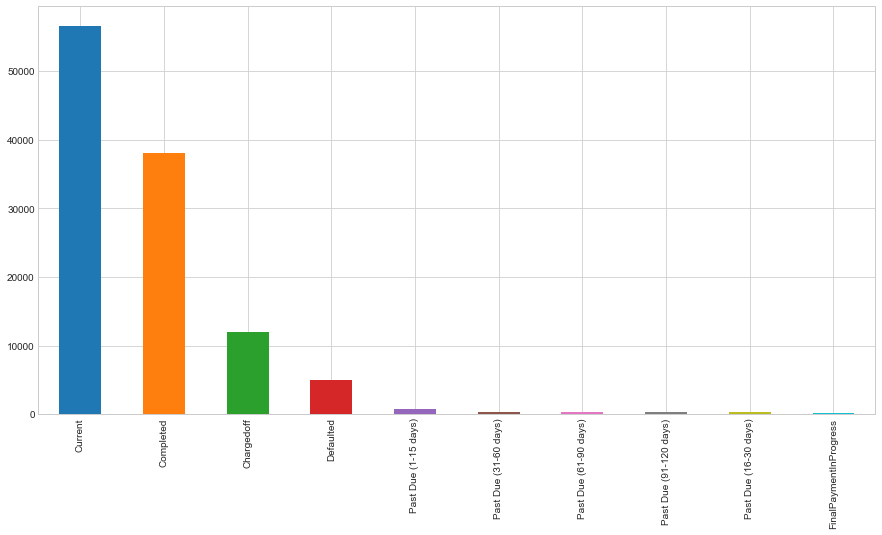

In [52]:
loanData['LoanStatus'].value_counts().head(10).plot.bar()

In [53]:
df_historical = loanData[loanData["LoanStatus"] != "Current"]
df_historical["LoanStatus"].value_counts()

Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

In [56]:
#Encode all completed loans as 1, and all delinquent, chargedoff, cancelled and defaulted loans as 0
df_historical["LoanStatus"] = (df_historical["LoanStatus"] == "Completed").astype(int)
df_historical["LoanStatus"][:10]

C:\Users\ish\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0     1
2     1
11    1
12    0
15    0
17    0
21    1
23    0
26    1
27    1
Name: LoanStatus, dtype: int32

What does this plot tell us? It says customer with current loan status are far more than other status. We might ask what percent of the total is current status? This bar chart tells us absolute numbers, but it's more useful to know relative proportions.

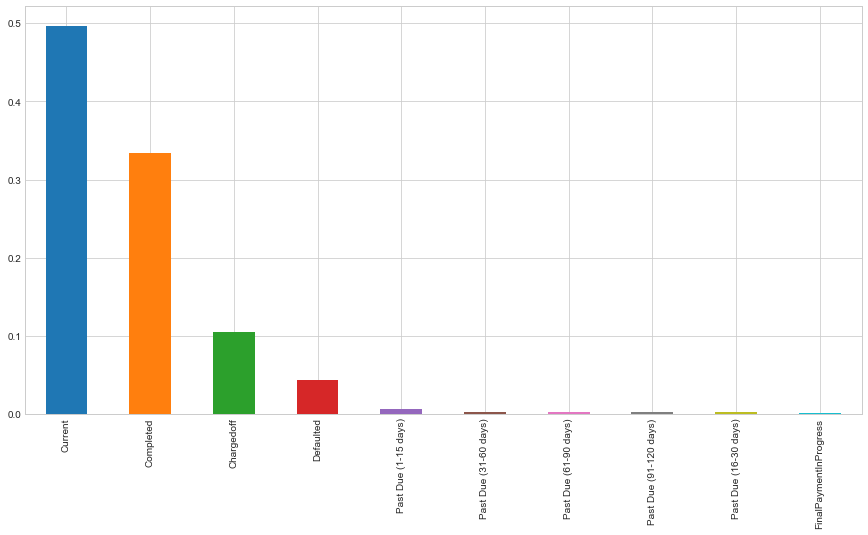

In [57]:
(loanData['LoanStatus'].value_counts().head(10) / len(loanData)).plot.bar()

(0, 1)

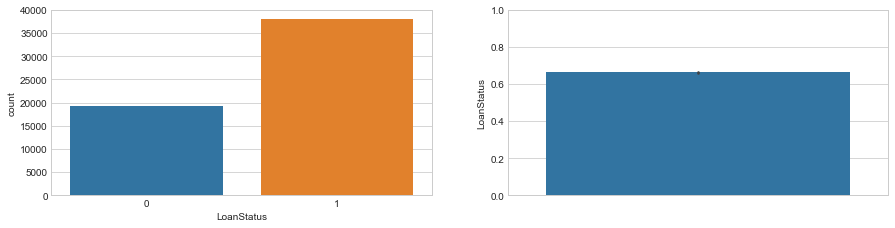

In [58]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.countplot(df_historical["LoanStatus"])

ax2 = fig.add_subplot(222)
sns.barplot(y=df_historical["LoanStatus"]).set_ylim([0,1])

Loan statsu "current" almost 50% of total loan status

### Exploring credit history 

(0, 20)

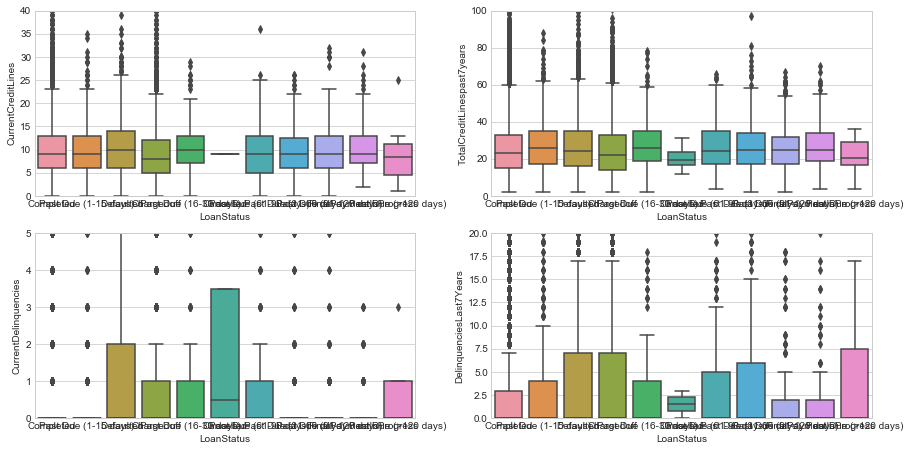

In [86]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.boxplot(x="LoanStatus", y="CurrentCreditLines", data=df_historical).set_ylim([0,40])

ax2 = fig.add_subplot(222)
sns.boxplot(x="LoanStatus", y="TotalCreditLinespast7years", data=df_historical).set_ylim([0,100])

ax3 = fig.add_subplot(223)
sns.boxplot(x="LoanStatus", y="CurrentDelinquencies", data=df_historical).set_ylim([0,5])

ax4 = fig.add_subplot(224)
sns.boxplot(x="LoanStatus", y="DelinquenciesLast7Years", data=df_historical).set_ylim([0,20])

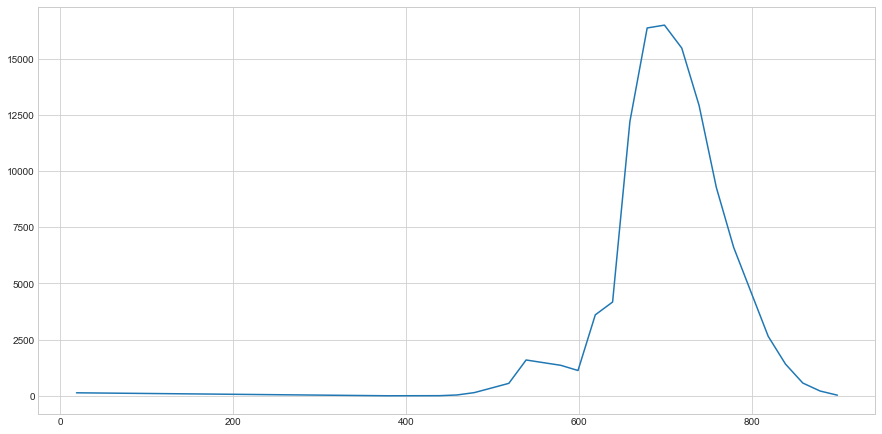

In [59]:
loanData['CreditScoreRangeUpper'].value_counts().sort_index().plot.line()

Here, I plotted a line chart which can pass over any number of many individual values, making it the tool of first choice for distributions with many unique values or categories.

Here I will plot both credit (lower & upper) score to get an idea of each ordinal variable's distribution.


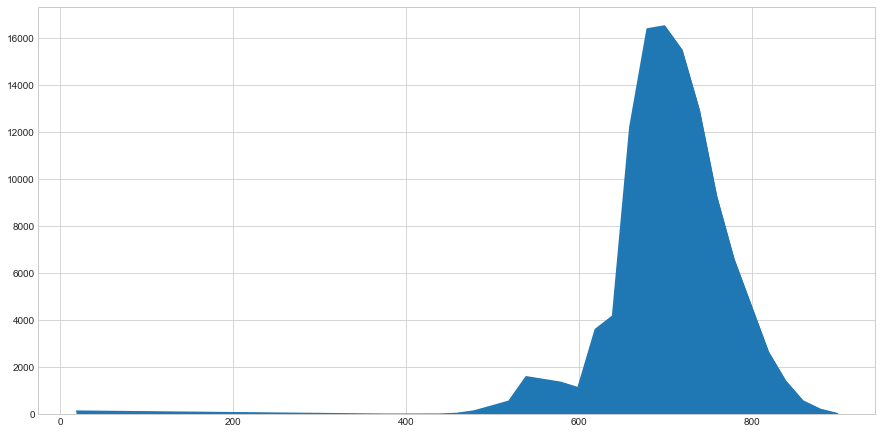

In [60]:
loanData['CreditScoreRangeUpper'].value_counts().sort_index().plot.area()

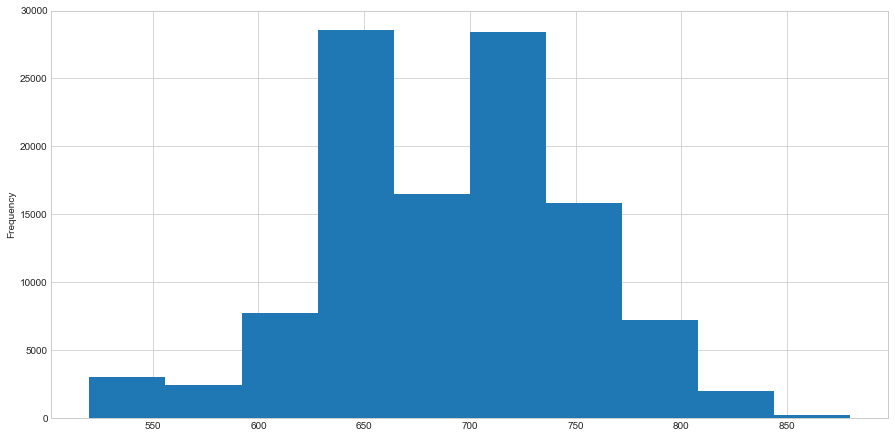

In [61]:
loanData[loanData['CreditScoreRangeLower'] > 500]['CreditScoreRangeLower'].plot.hist()

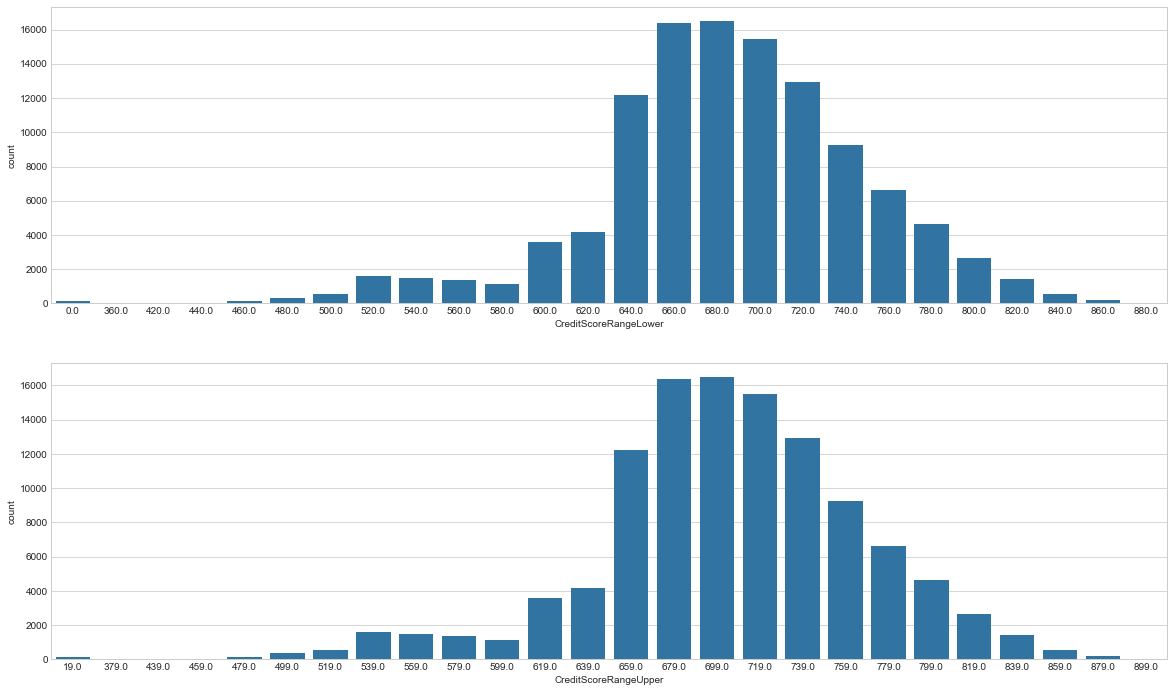

In [66]:
fig, ax = plt.subplots(nrows=2, figsize = [20,12])

default_color = sb.color_palette()[0]
sb.countplot(data = loanData, x = 'CreditScoreRangeLower', color = default_color, ax = ax[0])
sb.countplot(data = loanData, x = 'CreditScoreRangeUpper', color = default_color, ax = ax[1])

plt.show()


# Bivariate Exploration

To start off with, I want to look at the pairwise correlations present between features in the data.

In [67]:
numeric_vars = ['CreditScoreRangeLower', 'CreditScoreRangeUpper', 'OpenRevolvingAccounts', 'InquiriesLast6Months', 
               'RevolvingCreditBalance']
categoric_vars = ['LoanStatus', 'EmploymentStatus', 'IncomeRange']

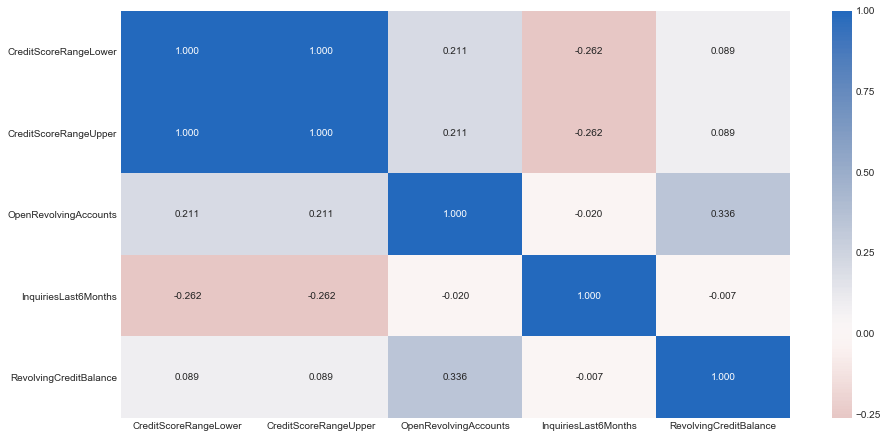

In [69]:
# correlation plot
sb.heatmap(loanData[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

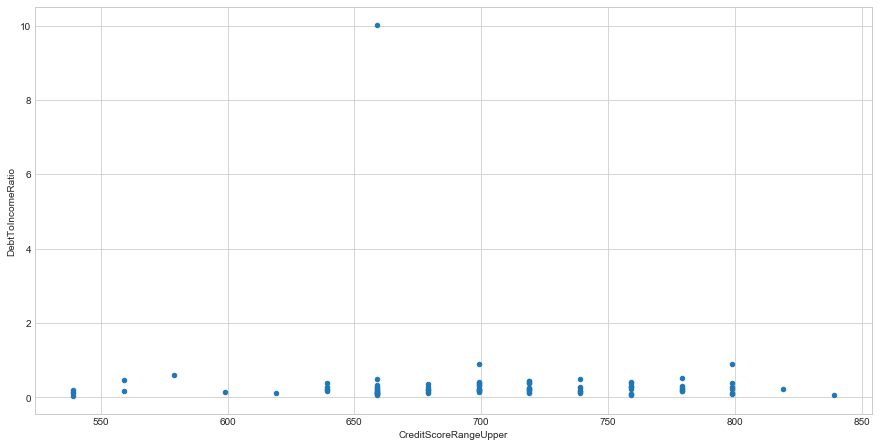

In [71]:
loanData[loanData['CreditScoreRangeUpper'] > 400].sample(100).plot.scatter(x='CreditScoreRangeUpper', y='DebtToIncomeRatio')

This plot shows us that Debt to ratio and upper rang credit score are weakly correlated: 

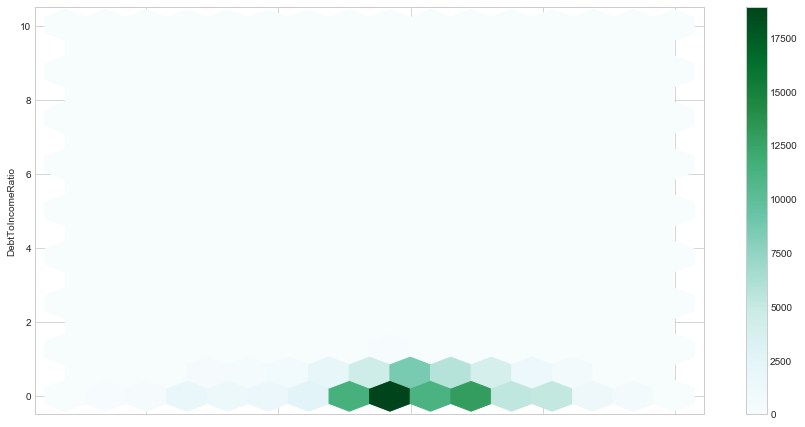

In [72]:
loanData[loanData['CreditScoreRangeUpper'] > 400 ].plot.hexbin(x='CreditScoreRangeUpper', y='DebtToIncomeRatio', gridsize=15)

In [73]:
#Remove outstanding loans
df_historical = loanData[loanData["LoanStatus"] != "Current"]
df_historical["LoanStatus"].value_counts()

Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

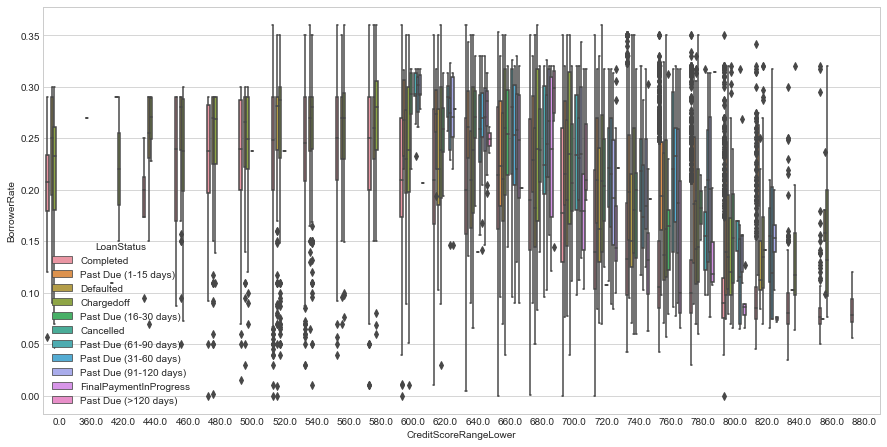

In [74]:
sns.boxplot(x="CreditScoreRangeLower", y='BorrowerRate', hue='LoanStatus', data=df_historical)

C:\Users\ish\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


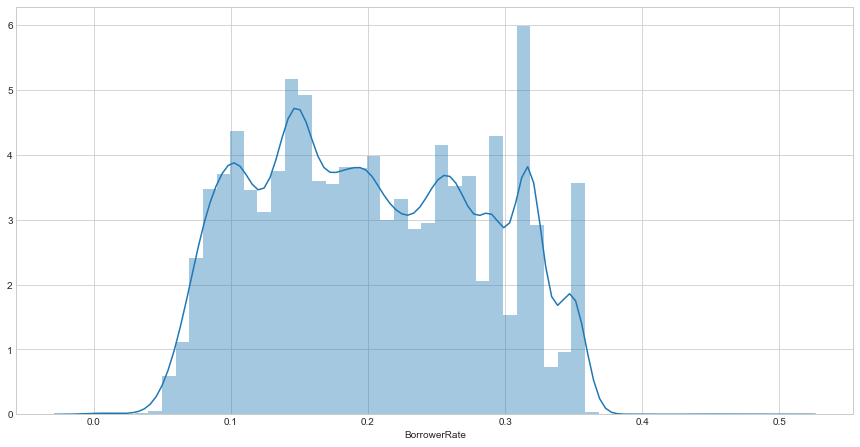

In [82]:
sns.distplot(df_historical["BorrowerRate"])

In [83]:
df_historical["BorrowerRate"].describe()

count    57361.000000
mean         0.201634
std          0.080952
min          0.000000
25%          0.136400
50%          0.198000
75%          0.269900
max          0.497500
Name: BorrowerRate, dtype: float64

The mean interest rate for all Prosper loans is a fairly substantial high 20.35%. From my experience this is as high as a credit card.

In [85]:
df_historical["Term"].value_counts()

36    51391
60     4418
12     1552
Name: Term, dtype: int64

### Conclusion

I have learned and happy with this project. I got great practice in cleaning and preprocessing a dataset, as well as using seaborn for some of my visualisations and, most importantly, choosing appropriate metrics for a particular problem definition. 

I beleive with some more time and practice, and learning, I could have explored other angles of the dataset. Since the the purpose of this analysis was not to make apply for a loan or make money, it was to learn and to practice. I will continue to explre the project outside of this project to apply predictive analytics where I will split the data into features and labels, as well as training and testing sets.